In [ ]:
# install required packages
conda create -n pysyft python=3.7
conda activate pysyft
conda install numpy jupyter notebook
conda install pytorch torchvision -c pytorch
pip install syft==0.2.9

In [20]:
# load required packages
import syft as sy
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim
import numpy as np
import torch

In [21]:
# create virtual workers
bob = sy.VirtualWorker(hook, id='bob')
alice = sy.VirtualWorker(hook, id='alice')
server_1 = sy.VirtualWorker(hook, id='server_1')
server_2 = sy.VirtualWorker(hook, id='server_2')
server_3 = sy.VirtualWorker(hook, id='server_3')

In [22]:
# clear workers objects
bob.clear_objects()
alice.clear_objects()
server_1.clear_objects()
server_2.clear_objects()
server_3.clear_objects()

<VirtualWorker id:server_3 #objects:0>

In [23]:
# add workers to the list of workers
bob.add_workers([alice, server_1, server_2, server_3])
alice.add_workers([bob, server_1, server_2, server_3])
server_1.add_workers([alice, bob, server_2, server_3])
server_2.add_workers([alice, bob, server_1, server_3])
server_3.add_workers([alice, bob, server_1, server_2])

<VirtualWorker id:server_3 #objects:0>

In [24]:
# load data and target, and send them to workers
data = torch.load('data.pt')
target = torch.load('target.pt')

data_train = data[0:6000]
target_train = target[0:6000]

data_val = data[6000:8000]
target_val = target[6000:8000]

data_test = data[8000:10000]
target_test = target[8000:10000]

bobs_data = data_train[0:3000].send(bob)
bobs_target = target_train[0:3000].send(bob)

alices_data = data_train[3000:6000].send(alice)
alices_target = target_train[3000:6000].send(alice)


In [25]:
# model training using FedAvg algorithm -- gradient averaging (LDP + MPC)
model = nn.Linear(2, 1)
train_loss_GradAvg = []
val_loss_GradAvg = []
for round_iter in range(1500):
    bobs_model = model.copy().send(bob)
    alices_model = model.copy().send(alice)
    opt = optim.SGD(params=model.parameters(), lr=0.1 * 500)

    bobs_weight_grad = 0
    bobs_bias_grad = 0
    for example, target in zip(bobs_data, bobs_target):
        weight_grad = th.mm(th.mm(example.copy().get().view(1, 2), bobs_model.weight.copy().get().transpose(1, 0)) + bobs_model.bias.copy().get() - target.copy().get(), example.copy().get().view(1, 2)) * 2
        weight_grad = weight_grad.data
        weight_grad = weight_grad / max(1, weight_grad.norm(1) / 3.9219e-04)
        bias_grad = (th.mm(example.copy().get().view(1, 2), bobs_model.weight.copy().get().transpose(1, 0)) + bobs_model.bias.copy().get() - target.copy().get()) * 2
        bias_grad = bias_grad.data.view(-1)
        bias_grad = bias_grad / max(1, bias_grad.norm(1) / 4.4978e-04)
        bobs_weight_grad += weight_grad
        bobs_bias_grad += bias_grad

    alices_weight_grad = 0
    alices_bias_grad = 0
    for example, target in zip(alices_data, alices_target):
        weight_grad = th.mm(th.mm(example.copy().get().view(1, 2), alices_model.weight.copy().get().transpose(1, 0)) + alices_model.bias.copy().get() - target.copy().get(), example.copy().get().view(1, 2)) * 2
        weight_grad = weight_grad.data
        weight_grad = weight_grad / max(1, weight_grad.norm(1) / 3.9020e-04)
        bias_grad = (th.mm(example.copy().get().view(1, 2), alices_model.weight.copy().get().transpose(1, 0)) + alices_model.bias.copy().get() - target.copy().get()) * 2
        bias_grad = bias_grad.data.view(-1)
        bias_grad = bias_grad / max(1, bias_grad.norm(1) / 4.3543e-04)
        alices_weight_grad += weight_grad
        alices_bias_grad += bias_grad

    bobs_model.get()
    alices_model.get()

    bobs_model.weight.grad = (bobs_weight_grad + th.tensor(np.random.laplace(0, 3.9219e-04 / 0.1, 2).reshape(1, 2), dtype=torch.float32)) / len(bobs_data)
    bobs_model.bias.grad = (bobs_bias_grad + th.tensor(np.random.laplace(0, 4.4978e-04 / 0.1, 1), dtype=torch.float32)) / len(bobs_data)
    alices_model.weight.grad = (alices_weight_grad + th.tensor(np.random.laplace(0, 3.9020e-04 / 0.1, 2).reshape(1, 2), dtype=torch.float32)) / len(alices_data)
    alices_model.bias.grad = (alices_bias_grad + th.tensor(np.random.laplace(0, 4.3543e-04 / 0.1, 1), dtype=torch.float32)) / len(alices_data)

    for param, alices_param, bobs_param in zip(model.parameters(), alices_model.parameters(), bobs_model.parameters()):
        param.grad = (alices_param.grad.fix_precision(base=10, precision_fractional=6).share(server_1, server_2, server_3) + bobs_param.grad.fix_precision(base=10, precision_fractional=6).share(server_1, server_2, server_3)).get().float_precision() / 2

    opt.step()

    pred = model(data_train)
    loss = ((pred - target_train) ** 2).sum() / len(data_train)
    train_loss = loss.data
    train_loss_GradAvg.append(round(train_loss.item(), 4))
    pred = model(data_val)
    loss = ((pred - target_val) ** 2).sum() / len(data_val)
    val_loss = loss.data
    val_loss_GradAvg.append(round(val_loss.item(), 4))
    print(str(round_iter+1) + ' train loss:' + str(train_loss) + ' val loss:' + str(val_loss))


1 train loss:tensor(1.9307) val loss:tensor(1.9652)
2 train loss:tensor(1.8452) val loss:tensor(1.8787)
3 train loss:tensor(1.7623) val loss:tensor(1.7948)
4 train loss:tensor(1.6813) val loss:tensor(1.7129)
5 train loss:tensor(1.6026) val loss:tensor(1.6332)
6 train loss:tensor(1.5259) val loss:tensor(1.5555)
7 train loss:tensor(1.4516) val loss:tensor(1.4802)
8 train loss:tensor(1.3788) val loss:tensor(1.4065)
9 train loss:tensor(1.3083) val loss:tensor(1.3351)
10 train loss:tensor(1.2397) val loss:tensor(1.2655)


KeyboardInterrupt: 

In [26]:
%matplotlib inline

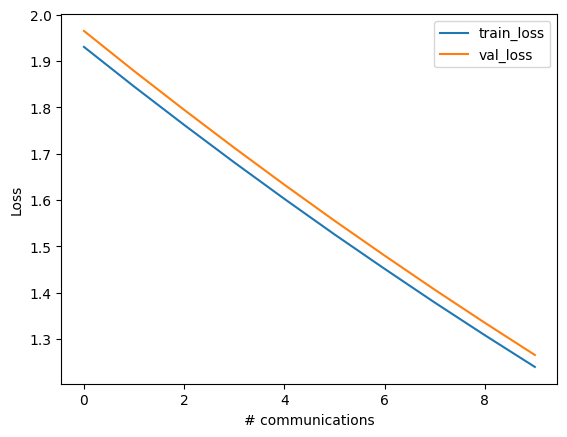

In [27]:
# plot learning curves
import matplotlib.pyplot as plt

plt.plot(train_loss_GradAvg[:], label='train_loss')
plt.plot(val_loss_GradAvg[:], label='val_loss')
plt.legend(loc='best')
plt.xlabel('# communications')
plt.ylabel('Loss')
plt.show()